# Model Training Notebook

This notebook is your guide to the processes behind the two key models in our analysis:

- **Latent Dirichlet Allocation (LDA):** A topic modeling technique used to uncover hidden themes within movie synopses. Here, we explore how the LDA model was trained, fine-tuned, and evaluated to identify the optimal number of topics that best represent our dataset.

- **Linear Regression:** A predictive model used to determine the relationship between movie features and their ratings. This section demonstrates how we trained and evaluated the model, including how we handled categorical and numerical features, and identified the most influential predictors of audience ratings.

By following along, you’ll gain insights into the methodologies, decisions, and outcomes that shaped our analysis. Let’s dive in and uncover the story behind the numbers!

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Analysis</p>
    <div style="padding: 0 0 2px 10px;">
    
**What will be covered :**
- **Part 1 :** Latent Dirichlet Allocation (LDA)
- **Part 2 :** Linear Regression

</div></div>
<br/>

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from src.utils.helpers import *

#LDA
import spacy
import nltk
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle

# Linear Regression 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# Part 1: Latent Dirichlet Allocation (LDA)

## 1.1 LDA Preprocessing

To preprocess the synopses, we use the `spacy` analyzer for English language. We apply the following pipeline to the synopses :

### Preprocess pipeline
1.   Tokenization
2.   Stop words, punctuation and numbers removal (except dates)
3.   Lemmatization
4.   Remove character names
5. Add bigrams


Removing stop words and character names before using LDA is important as those very frequent words are useless when defining global themes. Bigrams are sequences of two words that could capture additionnal informations so we add them.

In [2]:
movie_final = pd.read_csv('Data/LDA_df.csv') # Import LDA_df to extract data from it

synopses = movie_final['plot_synopsis'].tolist() #Convert synopses column to a list
print(f'Number of synopses : {len(synopses)}')

Number of synopses : 14604


,imdb_id,Movie name,plot_synopsis,tags,Movie genres,averageRating
0,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,['Fantasy'],4.4
1,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,"['Romantic comedy', 'Workplace Comedy', 'Black...",8.0
2,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good","['Inspirational Drama', 'Family Film', 'Drama'...",7.3


_Load the spacy analyzer in English_

_Preprocess synopses_

**Note:** The following cell performs preprocessing on movie synopses. It takes a while to run, since it processes a large dataset. To skip this cell you can use the resulting file saved in `Data/processed_data.txt` instead by setting `run_processing` to `False`.


In [4]:
from gensim.models.phrases import Phrases

run_processing = False

if run_processing:
    docs = list()
    for doc in nlp.pipe(synopses, n_process=5, batch_size=10):

        ents = doc.ents  # Get entities

        # Lemmatize tokens (running --> run) after removing numbers, punctuation, stopwords and entities.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and len(token) > 2 and token.ent_type_ == ""]

        # Add entities, but only if they are not character names and longer than 1 word (as it's usually character names not recognized as PERSON).
        doc.extend([str(entity) for entity in ents if len(entity) > 1 and entity.label_ != "PERSON"])
        docs.append(doc)

        # Save file
        path_file = 'Data/processed_data.txt'
        with open(path_file, "wb") as file:
            pickle.dump(docs, file)
else:
    path_file = 'Data/processed_data.txt'
    with open(path_file, "rb") as file:
        docs = pickle.load(file)

_Add bigrams_

In [5]:
# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token: # Token is a bigram, add to document.
            docs[idx].append(token)

Let's see the result of our preprocessing :

In [7]:
print(f'Original : {synopses[0]}')
print(f'Preprocessed : {docs[0]}')

Original : Two thousand years ago, Nhagruul the Foul, a sorcerer who reveled in corrupting the innocent and the spread of despair, neared the end of his mortal days and was dismayed. Consumed by hatred for the living, Nhagruul sold his soul to the demon Lords of the abyss so that his malign spirit would survive. In an excruciating ritual, Nhagrulls skin was flayed into pages, his bones hammered into a cover, and his diseased blood became the ink to pen a book most vile. Creatures vile and depraved rose from every pit and unclean barrow to partake in the fever of destruction. The kingdoms of Karkoth were consumed by this plague of evil until an order of holy warriors arose from the ashes. The Knights of the New Sun swore an oath to resurrect hope in the land. The purity of their hearts was so great that Pelor, the God of Light, gave the Knights powerful amulets with which to channel his power. Transcendent with divine might, the Knights of the New Sun pierced the shadow that had darkene

To prepare the data for LDA, we first create a dictionnary of all the words except ones that are too rare or too common. Then we create the bag-of-words representation of the documents.

In [8]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove too rare and too common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 35066


In [9]:
# Save the dictionary to a file
dictionary.save("src/models/dictionary.dict")

# Save the corpus to a file in Matrix Market format (or another supported format)
from gensim.corpora import MmCorpus
MmCorpus.serialize("src/models/corpus.mm", corpus)


### Run LDA for various number of topics 

**Note:** Again this cell takes very long to run. Set `run_lda` to `False` to skip it and load the resulting coherence files.


In [10]:
run_lda = False
if run_lda:
    from gensim.models import LdaMulticore
    from gensim.models import KeyedVectors

    model_w2v = KeyedVectors.load("src/models/word2vec.model") #Get Word2Vec model
    seed = 42
    params = {'passes': 10, 'random_state': seed}
    coherence_sim = []
    models = []
    topic_number = range(4, 19, 1)

    for topic in topic_number:
        model = LdaMulticore(corpus=corpus, num_topics=topic, id2word=dictionary, workers=6,
                        passes=params['passes'], random_state=params['random_state'])
        models.append(model)
        cohe = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_sim.append(get_similarity(model, model_w2v))

# Save coherence scores
with open('src/models/coherence_sim.pkl', "rb") as file:
    coherence_sim = pickle.load(file)

## Part 2: Linear Regression 

In this part, we want to determine wheter the ratings can be explained by other features. To do so, we will test three different models for linear regression. The first model will use only numerical features, the second will use only categorical features, and the third will combine both numerical and categorical features. This approach will allow us to determine which model performs best and identify which features have the most significant impact on the average ratings.

## 2.1 Model training

In [2]:
# Load the dataset
data = pd.read_csv('Data/features_df.csv')

# Select relevant columns and target variable
features = ['tags', 'Movie genres', 'Movie languages', 'Movie countries', 'Movie runtime', 'IMDB Box-office', 'numVotes']
target = 'averageRating'

# Drop rows with missing values in features or target
data_cleaned = data[features + [target]].dropna()

# Define textual and numerical features
textual_features = ['tags', 'Movie genres', 'Movie languages', 'Movie countries']
numerical_features = ['Movie runtime', 'IMDB Box-office', 'numVotes']

# Extract numerical features
numerical_features_data = data_cleaned[numerical_features].fillna(0).values

# Define target variable
y = data_cleaned[target]

_Comment: In this analysis, we removed all rows with missing values, as they need to be handled for linear regression. We tested two options: keeping the 'box office' feature (which has many missing values) and removing those rows, or dropping 'box office' to keep more data. Keeping 'box office' and removing the rows gave better results, so we chose this approach._

The first model that we test is the one with numerical data.

In [3]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features_data_scaled = scaler.fit_transform(numerical_features_data)

# Train model
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(numerical_features_data_scaled, y, test_size=0.2, random_state=42)
rmse_num, r2_num, y_pred_num, model_num = train_and_evaluate(X_train_num, X_test_num, y_train_num, y_test_num)

Next is the model containing categorical data.

_Note: For the categorical features, we used TF-IDF vectorization, a technique that transforms textual data into numerical representations, allowing the model to handle complex categorical information. We found this methods to be beter than one hot encoding._

In [4]:
# Apply TF-IDF vectorization to each feature independently
tfidf_vectorizers = {}
tfidf_matrices = {}

for feature in textual_features:
    vectorizer = TfidfVectorizer(max_features=500)
    tfidf_matrices[feature] = vectorizer.fit_transform(data_cleaned[feature].fillna(''))
    tfidf_vectorizers[feature] = vectorizer

# Combine all TF-IDF matrices
X_combined = hstack([tfidf_matrices[feature] for feature in textual_features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
rmse_cat, r2_cat, y_pred_cat, model_cat = train_and_evaluate(X_train, X_test, y_train, y_test)

And finally both combined.

In [5]:
# Combine TF-IDF features with numerical features
X_combined_reduced = hstack([X_combined, numerical_features_data_scaled])

# Train-test split
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_combined_reduced, y, test_size=0.2, random_state=42)
rmse_comb, r2_comb, y_pred_comb, model_comb = train_and_evaluate(X_train_comb, X_test_comb, y_train_comb, y_test_comb)


Now that we have all the model we will compare them.

In [6]:
# Compare the results
comparison_results = pd.DataFrame({
    'Feature Set': ['Numerical Only', 'Categorical Only', 'Combined'],
    'RMSE': [rmse_num, rmse_cat, rmse_comb],
    'R²': [r2_num, r2_cat, r2_comb]
})

print(comparison_results)

        Feature Set      RMSE        R²
0    Numerical Only  0.975319  0.130247
1  Categorical Only  0.907500  0.246998
2          Combined  0.884650  0.284440


The results show that categorical features do a better job at predicting movie ratings, as they explain 25% of the variation in ratings (R² = 0.246998). In comparison, numerical features explain only 13% of the variation (R² = 0.130247). When we combine both types of features, the model works even better, explaining 28% of the variation (R² = 0.284440) and having the lowest error (RMSE = 0.884650). This means that using both categorical and numerical features together gives the best results.

Lets now analyze the significant features

In [7]:
results = analyze_feature_importance(textual_features=textual_features, tfidf_matrices=tfidf_matrices, tfidf_vectorizers=tfidf_vectorizers, model=model_comb, rmse=rmse_comb, r2=r2_comb, numerical_features=numerical_features,  numerical=True)

Mean Squared Error (MSE): 0.8846504462300893
R-squared (R²): 0.2844398730501657

Feature: tags
Top Positive Features:
  non: 0.9889
  historical: 0.9232
  atmospheric: 0.7971
  realism: 0.7877
  queer: 0.7734
  horror: 0.6777
  claustrophobic: 0.6723
  melodrama: 0.6509
  whimsical: 0.6509
  gothic: 0.6439
Top Negative Features:
  stupid: -0.6546
  pornographic: -0.5529
  fiction: -0.4647
  comic: -0.1441
  absurd: -0.1246
  boring: -0.0914
  christian: -0.0820
  adult: -0.0770
  magical: -0.0309
  violence: -0.0205

Feature: Movie genres
Top Positive Features:
  period: 11.0128
  films: 3.6277
  supermarionation: 2.7029
  japanese: 2.6300
  chinese: 2.2357
  samurai: 1.9149
  animated: 1.9064
  female: 1.7703
  cavalry: 1.5081
  law: 1.5055
Top Negative Features:
  filipino: -14.0698
  piece: -10.7665
  hardcore: -6.2392
  opera: -3.6352
  movies: -3.1868
  natural: -2.9200
  swashbuckler: -2.7093
  combat: -2.3422
  criminal: -2.2448
  master: -2.2448

Feature: Movie languages
Top Po

Textual features, such as tags, genres, and languages, play a dominant role in predicting movie ratings, indicating that audience perception and content themes are more influential than numerical attributes like runtime or box office. Additionally, niche cultural elements, including specific languages and countries, strongly impact ratings, highlighting the significance of audience preferences and the value of diversity in movie content.

The top features in each category that influence ratings will be analyzed in much details in `results.ipynb`

## 2.2 Model performance

Here, we analyze our model's performance by plotting relevant metrics.

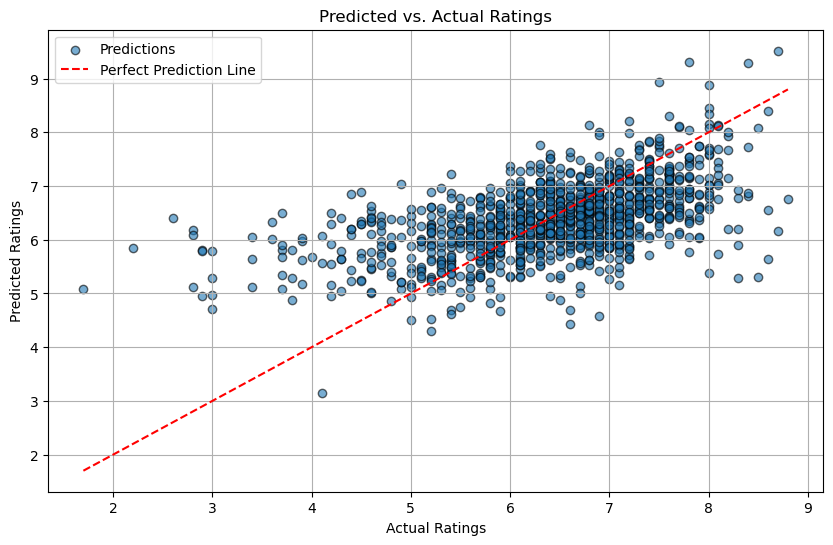

In [8]:
# Predicted vs. Actual Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test_comb, y_pred_comb, alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([min(y_test_comb), max(y_test_comb)], [min(y_test_comb), max(y_test_comb)], 
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs. Actual Ratings')
plt.legend()
plt.grid()
plt.show()

This scatter plot shows the relationship between the model's predicted ratings and the actual ratings. The red dashed line represents perfect predictions where the predicted and actual ratings are equal. Most predictions cluster near this line, especially in the middle range of ratings (5 to 7). However, the spread increases at the extremes, indicating that the model struggles to predict very high or very low ratings accurately. This suggests that while the model performs well for average-rated movies, additional features or non-linear modeling may be needed to handle edge cases.

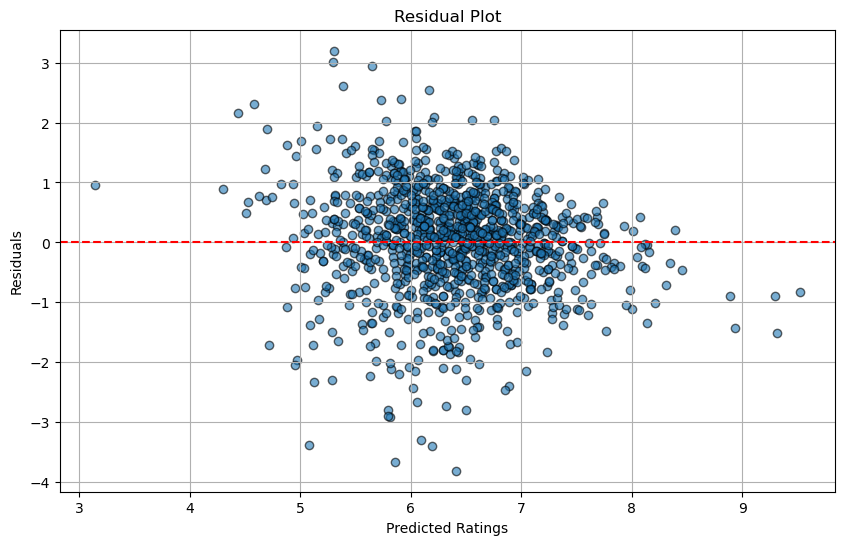

In [9]:
# Residual Plot
residuals_comb = y_test_comb - y_pred_comb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_comb, residuals_comb, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid()
plt.show()

The residual plot help visualizes the differences between actual and predicted ratings (residuals) plotted against the predicted ratings. Ideally, residuals should be randomly scattered around the zero-error line (red dashed line). Here, the residuals are mostly centered around zero, indicating no strong systematic bias in the predictions. However, there is some spread, particularly at higher predicted ratings, suggesting the model's performance weakens for certain types of movies. 

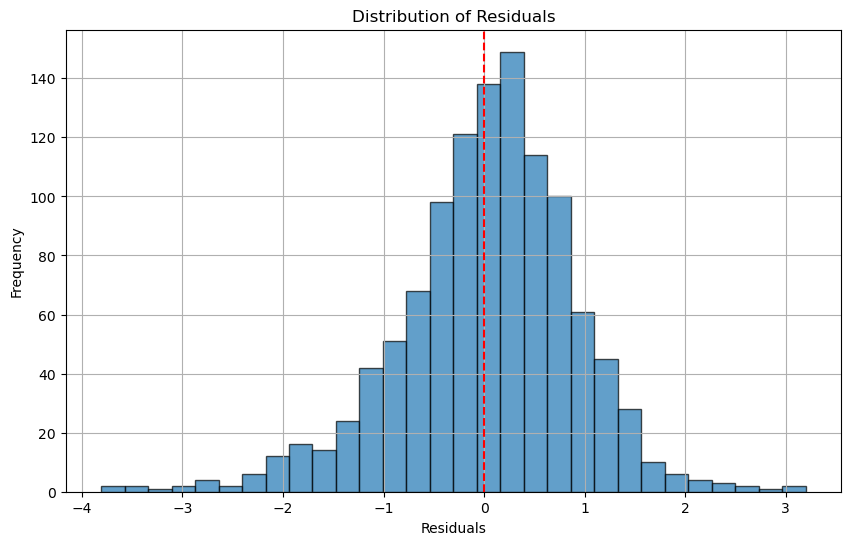

In [10]:
# Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals_comb, bins=30, alpha=0.7, edgecolor='k')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid()
plt.show()


The histogram shows the frequency distribution of residuals, with a red dashed line at zero representing perfect predictions. The residuals are symmetrically distributed and centered around zero, which is a good sign for a regression model. Most residuals fall within the range of -2 to +2, indicating that the model generally makes accurate predictions. However, the presence of outliers in the tails suggests there are a few movies for which the model struggles to predict ratings accurately. These outliers may point to missing features or complexities not captured by the model.

## 2.3 Better than random model ? 

Finally, we will ensure our model is better than a random one. To do so, we will randomly shuffle the x-axis many time to compare it with our model performance results. 

In [11]:
# Call the test_significance function
rmse_shuffled_list, r2_shuffled_list = test_significance(X_combined_reduced=X_combined_reduced, y=y, rmse_comb=rmse_comb, r2_comb=r2_comb,n_iterations=100)


Shuffled Model Performance with Statistical Significance   Metric  Combined Model  Random Model (Mean)  \
0   RMSE         0.88465             1.125373   
1     R²         0.28444            -0.158678   

   Mean Difference (Combined - Random)       p-value  
0                             0.240723  9.405454e-95  
1                            -0.443118  9.400460e-89  


The combined model is significantly better than the random model in both RMSE and $R^2$, with extremely low p-values showing the robustness and consistency of this difference. This validates that the combined model effectively captures meaningful relationships in the dataset.